We re-create numerical artefacts in the implementation of GPR with a periodic kernel for forward prediction. 
We consider a simple truth trajectory given by a deterministic sine curve. Next, we configure the GPRP algorithm and plot predictions. 

To get started, I import some python software I will need:

In [2]:
import sys 
sys.path.append('../../../')
from plot_tools.fig_preamble import * # imports numpy, matplotlib, Py2PDF, plot_helper_funcs, plot_figstyle_sheet
import GPy

/home/riddhisw/anaconda2/lib/python2.7/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:
/home/riddhisw/anaconda2/lib/python2.7/site-packages/matplotlib/lines.py:1182: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markeredgecolor != ec:


In [3]:
from gpr.common import get_data, simple_unlearnable_sine
from data_tools.load_raw_cluster_data import LoadExperiment as le
from plot_tools.plot_figstyle_sheet import color_pallete, predmarker, COLOURDICT, STYLEDICT

I also set up filepaths for saving data

In [5]:
ver=0
datapath = '../../../DATA_v'+str(ver)+'_/' #v'+str(ver)+'/DATA_v'+str(ver)+'/'
datafile = 'GPR_kappa_demo'

Now, let's consider how to configure the GPRP algorithm with limited apriori information about the truth.
In our application, let $\Delta t$ represent the shortest possible time-spacing in our procedure between two sequential measurements from an experiment, and let $\Delta t N_T$ represent the longest possible time spacing observed in the measurement record. 

We use physical arguments to link the periodicity and the lengthscale to the longest and shortest timescales of the observed system during training. In configuring a GPR algorithm, one decides or optimises $\omega_0^{(B)}$. For the physically set paramter, $\Delta t$ in our procedure, a classical analysis suggests that one needs $2 \pi /(\Delta t \omega_0^{(B)})$ for a computational method to resolve Fourier components of true noise to an order $\omega_0^{(B)}$. Further, any changes in the continuous process below $\Delta t$ will not be observed. These reasons lead us to propose the following initial conditions for kernel hyperparameters at the outset of a procedure:, namely:

    - p = N_train
    - l = 3 * Delta T 
    


In [3]:
# Set experimental parameters
n_train = 2000
Delta_T = 0.001
n_predict = 150
n_testbefore=50

In [4]:
# Set initial starting values for L-BFGS-B OPtimiser in GPy
sigma_0 = 1.0
R_0 =  1.0

In [5]:
# Set length scale and periodicity initial values for L-BFGS-B OPtimiser in GPy
length_scale_0 = 3.0*Delta_T
period_0 = 2000.0

true = 9.0/3.0
multipler = 7. # must be an integer
spacing = true / multipler
steps = (1./ spacing)/ 0.001
print steps
print spacing

print basis
print true / (1./(2000*0.001)) # integer

We now implement (a) manual constraints on noise variances and periodicities and (b) optimalised noise variances but constrained periodicities and (c) full optimised GPRP model 

In [6]:
true_freq = (9., 10.)
noise_variances = ((sigma_0, R_0) , (10.0, 10.0))
noiselabel= ['No Opt.', 'Opt.']
periodicities = ((2000, 2001), (2070., 2071.)) #, (10**4, 10**4), (10**6, 10**6))
offsets = [int(n_train- periodicities[idx_x][0]) for idx_x in xrange(len(periodicities))]
offsets

[0, -70]

In [7]:
pred_list= np.zeros((len(true_freq),len(periodicities), len(noise_variances), n_predict+n_testbefore))

print pred_list.shape

(2, 2, 2, 200)


Fourier resolution at training 0.5
True Frequency is 3.0


 ../../../../../gpr/common.py:97: VisibleDeprecationWarning:using a non-integer number instead of an integer will result in an error in the future
 ../../../../../gpr/common.py:98: VisibleDeprecationWarning:using a non-integer number instead of an integer will result in an error in the future


('Commence GPRP for:', 0, 0, 0)

Name : gp
Objective : 2344.80349412
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  gp.                       |   value  |   constraints   |  priors
  std_periodic.variance     |     1.0  |       +ve       |        
  std_periodic.period       |  2000.0  |  2000.0,2001.0  |        
  std_periodic.lengthscale  |   0.003  |       +ve       |        
  Gaussian_noise.variance   |     1.0  |       +ve       |        
Succeed - optimised params are

Name : gp
Objective : 2344.80349412
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  gp.                       |   value  |   constraints   |  priors
  std_periodic.variance     |     1.0  |       +ve       |        
  std_periodic.period       |  2000.0  |  2000.0,2001.0  |        
  std_periodic.lengthscale  |   0.003  |       +ve       |        
  Gaussian_noise.variance   |     1.0  |       +ve       |        
('Commence GP

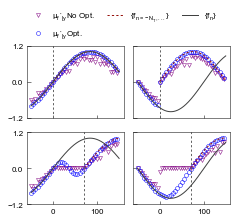

In [8]:
gs = gridspec.GridSpec(2, 2,
                       left=0.15, right=0.985, 
                       top=0.9, bottom=0.1, 
                       wspace=0.1, hspace=0.2)

fig2 = plt.figure(figsize=(cm2inch(8.6),cm2inch(7)))

FCOLOR = ['purple', 'blue', 'k']
FSTY = ['v', 'o', ':']
FLABELS = ['Perfect Learning', 'Imperfect Learning $p=n_T \quad p > n_T$']



for idx_freq in xrange(len(true_freq)): 

    X, Y, TestX, truth, msmts = simple_unlearnable_sine(nt=n_train, delta_t = Delta_T, 
                                                        f0 = true_freq[idx_freq], 
                                                        testpts=n_predict, randomise='y')
    
    for idx_per in xrange(len(periodicities)): 

        ax=0
        ax = fig2.add_subplot(gs[idx_per, idx_freq])       # noise variance are trajectories on a graph
        
        
        for idx_noise in xrange(len(noise_variances)): 
        
        
            # Reset
            kernel_per=0
            gauss=0
            exact=0
            m1=0
            
            
            # Built model
            kernel_per = GPy.kern.StdPeriodic(1, period=period_0, variance=sigma_0, 
                                              lengthscale=length_scale_0)
            gauss = GPy.likelihoods.Gaussian(variance=R_0)
            exact = GPy.inference.latent_function_inference.ExactGaussianInference()
            m1 = GPy.core.GP(X=X, Y=Y, kernel=kernel_per, likelihood=gauss, inference_method=exact)

            # Add constraints
            m1.std_periodic.period.constrain_bounded(periodicities[idx_per][0], periodicities[idx_per][1])
            if idx_noise != 0:
                m1.std_periodic.variance.constrain_bounded(0, noise_variances[idx_noise][0])
                m1.Gaussian_noise.variance.constrain_bounded(0, noise_variances[idx_noise][0])
            
            print("Commence GPRP for:", idx_freq, idx_per, idx_noise)
            print(m1)
            
            # Try optimise
            try:
                if idx_noise != 0:
                    m1.optimize(optimizer=None, messages=False)  # no pref optimiser
                pred_list[idx_freq, idx_per, idx_noise, :] = m1.predict(TestX)[0].flatten()
                print("Succeed - optimised params are")
                print(m1)
        
            except:
                print("Failed", idx_freq, idx_per, idx_noise)
        
            # plot predictions n > 0
            ax.plot(range(-n_testbefore, n_predict, 5), pred_list[idx_freq, idx_per, idx_noise, :][::5], # thin out by plotting every 5th msmt
                    FSTY[idx_noise], markerfacecolor='None', markersize=4, 
                    markeredgecolor= FCOLOR[idx_noise], 
                    color= FCOLOR[idx_noise], 
                    lw= 1.0, 
                    markeredgewidth=0.5,
                    label=r'$\mu_{f^*|y}$', alpha=1.)
        
        # plot the truth n = 0
        ax.plot(range(-offsets[idx_per], n_predict, 1), truth[0:n_predict + offsets[idx_per]], 
                      ':', color=COLOURDICT['GPRP2'], lw=1.0,#markersize=1, 
                      label=r'$ \{f_{n= -N_T,...} \} $' ) # offset is annoyingly a negative value.

        ax.axvline(x=-offsets[idx_per], ls=':', lw=1.0, 
                   color=COLOURDICT['DATA'])
        ax.text(-offsets[idx_per] + 2, -0.8, r'$\kappa = $%s'%(np.round(-offsets[idx_per])))
        
        # plot the truth n > 0
        ax.plot(range(-n_testbefore, n_predict, 1), truth[n_train - n_testbefore : ], 
            '-', color=COLOURDICT['TRUTH'], lw=1.0, #markersize=1, 
            label=r'$ \{f_n \}$' )

        # Formatting
        if idx_per ==0: # top row
            ax.set(xticklabels=[])
        if idx_freq ==1: # second column
            ax.set(yticklabels=[])
        ax.set_ylim([-1.2, 1.2])
        ax.tick_params(direction='in', which='both')
        ax.yaxis.set_major_locator(ticker.LinearLocator(numticks=3))
        #ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=3))
        ax = set_font_sizes(ax, fsize, Fsize)
        if idx_freq==0 and idx_per==0:
            ax.legend(loc=3,  fontsize=fsize, frameon=False, bbox_to_anchor=(0., 1.02, 2., .102), 
                     ncol=3, mode="expand", borderaxespad=0.)
            #ax.legend(loc=0, frameon=False)

    
fig2.savefig(savefig2+figname2+'.svg', format='svg', dpi=my_dpi)
plt.show()
plt.close()

In [9]:
np.savez(figdata+figname2, pred_list=pred_list)